# Table of Content
- [Imports](#imports)
- [Resources](#resources)
- [Load Data Sets](#load-data-sets)
- [Create Labels](#create-labels)
	- [Price Label](#price-label)
	- [Busiest days label](#busiest-days-label)
	- [Busiest days (plural- 2 busiest days, 2 slowest days, other days)](#busiest-days-(plural--2-busiest-days,-2-slowest-days,-other-days))
	- [Busiest period of day label](#busiest-period-of-day-label)
	- [Busiest hours for different days](#busiest-hours-for-different-days)
- [Export Data](#export-data)


## Imports [#](#table-of-content)

In [2]:
from pathlib import Path

import pandas as pd

## Resources [#](#table-of-content)

In [3]:
# project folder
project_folder = Path(r"C:\Users\vynde\Desktop\CareerFoundry Data Analytics\Data Immersion - 4 Python Fundamentals for Data Analysts\Instacart_Basket_Analysis")

# resource folders
prepared_data_folder = project_folder / "02_Data" / "Prepared_Data"

# input files
orders_products_merged_data_file = prepared_data_folder / "orders_products_merged.pkl"

# output files
orders_products_merged_updated_data_file = prepared_data_folder / "orders_products_merged_updated.pkl"

## Load Data Sets [#](#table-of-content)

In [4]:
# load data sets
df_ords_prods_merged = pd.read_pickle(orders_products_merged_data_file)

In [5]:
df_ords_prods_merged.head()

,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,prices
0,2539329,1,1,2,8,0.0,196,1,0,Soda,77,7,9.0
1,2398795,1,2,3,7,15.0,196,1,1,Soda,77,7,9.0
2,473747,1,3,3,12,21.0,196,1,1,Soda,77,7,9.0
3,2254736,1,4,4,7,29.0,196,1,1,Soda,77,7,9.0
4,431534,1,5,4,15,28.0,196,1,1,Soda,77,7,9.0


## Create Labels [#](#table-of-content)

##### Price Label [#](#table-of-content)

In [6]:
# add price_label (High-range product: 15<price, Mid-range product: 5<price<=15, Low-range product: price<=5)
df_ords_prods_merged["price_label"] = df_ords_prods_merged["prices"].apply(
    lambda x: "High-range product" if x > 15 else "Mid-range product" if x > 5 else "Low-range product")
# check output
df_ords_prods_merged["price_label"].value_counts()

Mid-range product     21860860
Low-range product     10126321
High-range product      417678
Name: price_label, dtype: int64

##### Busiest days label [#](#table-of-content)

In [7]:
# add busiest_days (Busiest day: day with most orders, Least busy: day with least orders, Regulary busy: rest)
order_count_per_day = df_ords_prods_merged["orders_day_of_week"].value_counts()
order_count_per_day

0    6204182
1    5660230
6    4496490
2    4213830
5    4205791
3    3840534
4    3783802
Name: orders_day_of_week, dtype: int64

In [8]:
# initial version to create busiest_day column; takes way too long with lambda and apply!!
this_cell_executes_fast = True
if this_cell_executes_fast:
    df_ords_prods_merged["busiest_day"] = df_ords_prods_merged["orders_day_of_week"].apply(
        lambda x: "Busiest day" if x == order_count_per_day.idxmax() else "Least busy" if x == order_count_per_day.idxmin() else "Regulary busy")

In [9]:
# construct column
# set "Least busy" for the day 
df_ords_prods_merged.loc[df_ords_prods_merged["orders_day_of_week"]==order_count_per_day.idxmin(), "busiest_day"] = "Least busy"
df_ords_prods_merged.loc[df_ords_prods_merged["orders_day_of_week"]==order_count_per_day.idxmax(), "busiest_day"] = "Busiest day"
df_ords_prods_merged.loc[(df_ords_prods_merged["orders_day_of_week"]!=order_count_per_day.idxmin()) 
                         & (df_ords_prods_merged["orders_day_of_week"]!=order_count_per_day.idxmax()), "busiest_day"] = "Regulary busy"

In [10]:
# check output
df_ords_prods_merged.busiest_day.value_counts()

Regulary busy    22416875
Busiest day       6204182
Least busy        3783802
Name: busiest_day, dtype: int64

##### Busiest days (plural- 2 busiest days, 2 slowest days, other days) [#](#table-of-content)

In [11]:
# day indices sorted by value counts
day_index_desc_ord_cnt= list(order_count_per_day.index)
day_index_desc_ord_cnt

[0, 1, 6, 2, 5, 3, 4]

In [12]:
# change values in busiest_day column to "Busiest days"  WHERE  day is one of the first two days
df_ords_prods_merged.loc[df_ords_prods_merged.orders_day_of_week.isin(day_index_desc_ord_cnt[:2]), "busiest_day"] = "Busiest days"
# change values in busiest_day column to "Least busy days"  WHERE  day is one of the last two days
df_ords_prods_merged.loc[df_ords_prods_merged.orders_day_of_week.isin(day_index_desc_ord_cnt[-2:]), "busiest_day"] = "Least busy days"
# change values in busiest_day column to "Regular busy"  WHERE  day is inbetween
# note that this isn't really necessary, values are already set
df_ords_prods_merged.loc[df_ords_prods_merged.orders_day_of_week.isin(day_index_desc_ord_cnt[2:-2]), "busiest_day"] = "Regulary busy"

Check Accuracy for busiest_day column

In [13]:
busiest_day_counts = df_ords_prods_merged.busiest_day.value_counts()
busiest_day_counts

Regulary busy      12916111
Busiest days       11864412
Least busy days     7624336
Name: busiest_day, dtype: int64

In [14]:
# check day indices for the 3 busy types
for val in busiest_day_counts.index:
    # day value counts for a busy type
    day_value_counts = df_ords_prods_merged.orders_day_of_week[df_ords_prods_merged.busiest_day == val].value_counts()
    print(day_value_counts)

6    4496490
2    4213830
5    4205791
Name: orders_day_of_week, dtype: int64
0    6204182
1    5660230
Name: orders_day_of_week, dtype: int64
3    3840534
4    3783802
Name: orders_day_of_week, dtype: int64


>Accuracy check conclusion

>Can be validated using `day_index_desc_ord_cnt = [0, 1, 6, 2, 5, 3, 4]`<br>
>Values are correct.

##### Busiest period of day label [#](#table-of-content)

Rather than by hour, create column with periods of time labeled “Most orders,” “Average orders,” and “Fewest orders.”

Determine grouping condition

<AxesSubplot:>

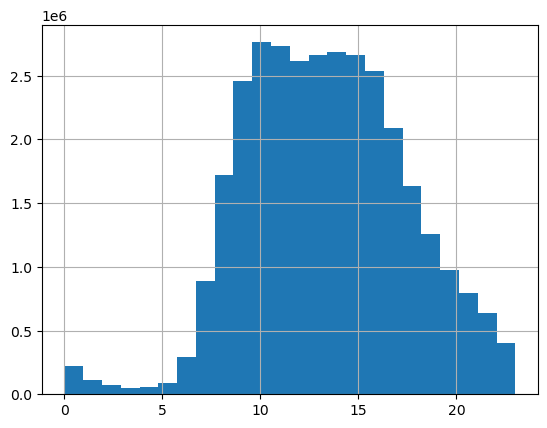

In [15]:
# histogram for occupation by hour
df_ords_prods_merged["order_hour_of_day"].hist(bins=24)

In [16]:
# set ranges for order frequency types by hour
ord_freq_by_hour_labels = ["Most orders", "Average orders", "Fewest orders"]
cum_pct_limit = [0, 0.2, 0.8, 1]  # first group: 0-20%, 2nd: 20%-80%, 3rd: 80%-100%

In [17]:
# cumulated percentage order counts for each hour (index) sorted by max value counts
cum_pct_ord_cnt_by_hour = df_ords_prods_merged.order_hour_of_day.value_counts().cumsum() / df_ords_prods_merged.shape[0]
cum_pct_ord_cnt_by_hour

10    0.085227
11    0.169663
14    0.252648
15    0.334801
13    0.416917
12    0.497724
16    0.575959
9     0.651695
17    0.716119
8     0.769139
18    0.819641
19    0.858472
20    0.888595
7     0.916093
21    0.940646
22    0.960218
23    0.972633
6     0.981598
0     0.988349
1     0.991919
5     0.994634
2     0.996774
4     0.998417
3     1.000000
Name: order_hour_of_day, dtype: float64

In [18]:
hours_sorted = cum_pct_ord_cnt_by_hour.index

# list of hour groups for frequency types
hour_groups = [hours_sorted[(limit1 < cum_pct_ord_cnt_by_hour) & (cum_pct_ord_cnt_by_hour <= limit2)] 
               for limit1, limit2 in zip(cum_pct_limit[:-1], cum_pct_limit[1:])]

hour_groups

[Int64Index([10, 11], dtype='int64'),
 Int64Index([14, 15, 13, 12, 16, 9, 17, 8], dtype='int64'),
 Int64Index([18, 19, 20, 7, 21, 22, 23, 6, 0, 1, 5, 2, 4, 3], dtype='int64')]

In [19]:
# finally create new column with labels according to desired grouping
for ord_freq_label, hour_group in zip(ord_freq_by_hour_labels, hour_groups):
    df_ords_prods_merged.loc[df_ords_prods_merged.order_hour_of_day.isin(hour_group), "busiest_period_of_day"] = ord_freq_label

Frequency

In [20]:
df_ords_prods_merged.busiest_period_of_day.value_counts()

Average orders    19425943
Fewest orders      7481016
Most orders        5497900
Name: busiest_period_of_day, dtype: int64

Keep in mind that the busiest hours were determined for all hours of the whole week

##### Busiest hours for different days [#](#table-of-content)


For a more accurate investigation we should consider seperating the days. Occupation by hour might change from day to day

<AxesSubplot:xlabel='orders_day_of_week,order_hour_of_day'>

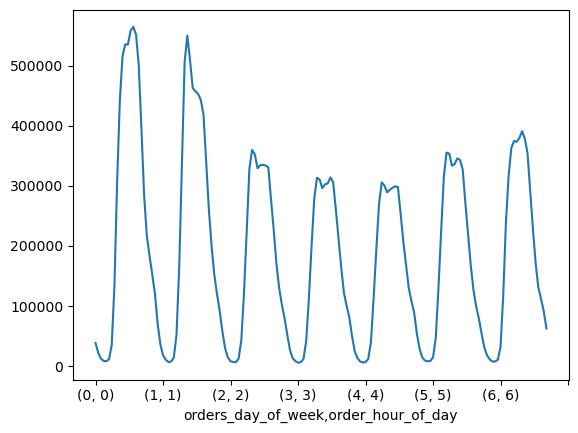

In [21]:
# visualization of the hourly order counts for all days
df_ords_prods_merged.groupby(["orders_day_of_week", "order_hour_of_day"]).size().plot()

>Besides the total order count, the timeline of order counts per hour look very similar across all days <br>

Regardless, let us examine the hourly grouping for each day, similar to the previous analysis.

In [22]:
for day in range(7):
    pointer = df_ords_prods_merged.orders_day_of_week==day
    cum_pct_ord_cnt_by_hour = df_ords_prods_merged[pointer].order_hour_of_day.value_counts().cumsum() / df_ords_prods_merged[pointer].shape[0]
    hours_sorted = cum_pct_ord_cnt_by_hour.index

    hour_groups = [hours_sorted[(limit1 < cum_pct_ord_cnt_by_hour) & (cum_pct_ord_cnt_by_hour <= limit2)] 
                   for limit1, limit2 in zip(cum_pct_limit[:-1], cum_pct_limit[1:])]
    print(hour_groups)

[Int64Index([14, 13], dtype='int64'), Int64Index([15, 11, 12, 10, 16, 9, 17, 8], dtype='int64'), Int64Index([18, 19, 20, 21, 7, 22, 23, 0, 6, 1, 2, 5, 3, 4], dtype='int64')]
[Int64Index([10, 11], dtype='int64'), Int64Index([9, 12, 13, 14, 15, 16, 17, 8], dtype='int64'), Int64Index([18, 19, 7, 20, 21, 22, 23, 6, 0, 1, 5, 2, 4, 3], dtype='int64')]
[Int64Index([10, 11], dtype='int64'), Int64Index([14, 13, 15, 16, 12, 9, 17, 18], dtype='int64'), Int64Index([8, 19, 20, 7, 21, 22, 23, 6, 0, 1, 5, 2, 3, 4], dtype='int64')]
[Int64Index([15, 10], dtype='int64'), Int64Index([11, 16, 14, 13, 12, 9, 17, 18], dtype='int64'), Int64Index([8, 19, 20, 7, 21, 22, 23, 6, 0, 1, 5, 2, 4, 3], dtype='int64')]
[Int64Index([10, 11], dtype='int64'), Int64Index([15, 16, 14, 13, 12, 9, 17, 18, 8], dtype='int64'), Int64Index([19, 20, 7, 21, 22, 23, 6, 0, 1, 5, 2, 4, 3], dtype='int64')]
[Int64Index([10, 11], dtype='int64'), Int64Index([14, 15, 13, 12, 16, 9, 17, 8], dtype='int64'), Int64Index([18, 19, 7, 20, 21, 22

>As we can see, hour 10 and 11 are not always the most occupied time periods.

## Export Data [#](#table-of-content)

In [23]:
# Export results
df_ords_prods_merged.to_pickle(orders_products_merged_updated_data_file)

In [24]:
df_ords_prods_merged.shape

(32404859, 16)